In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.gridspec as gridspec

import statsmodels.api as sm
import scipy.stats as stats
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA,FactorAnalysis
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.utils import resample

%matplotlib inline
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

- GRE(Graduate Record Examination): 미국 학부 과정의 SAT에 대응되는 미국의 대학원 수학 자격시험이다. 주로 미국 대학원에 유학갈 때 필요하나, 전세계적으로 통용된다. 과목으로는 verbal reasoning(언어논증), quantitative reasoning(수리논증), analytical writing(분석적 작문)의 3가지가 있으며, 버벌과 퀀트는 만점 170점, 최하점 130점으로 150점을 중앙에 두는 표준 분포를 이루며, 작문은 0~6점 스케일에 한 구간은 0.5점이다.  [참고](https://www.ets.org/gre/score-users/about/general-test/scoring.html)

- SOP: 진학 목적
- LOP: 추천서의 영향력
- TOEFL은 영어를 모국어로 하지 않는 사람들을 대상으로 응시자가 영어권의 대학 등 교육, 학술기관에서 수학할 수 있는지를 판단하는 중요한 척도로 활용된다.

- CGPA: 학부 성적

# EDA

In [ ]:
file_path = "" # train.csv file path
df = pd.read_csv(file_path)
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,4,322,110,3,3.5,2.5,8.67,1,0.80
1,19,318,110,3,4.0,3.0,8.80,0,0.63
2,203,340,120,5,4.5,4.5,9.91,1,0.97
3,251,320,104,3,3.0,2.5,8.57,1,0.74
4,275,315,100,1,2.0,2.5,7.95,0,0.58


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         320 non-null    int64  
 1   GRE Score          320 non-null    int64  
 2   TOEFL Score        320 non-null    int64  
 3   University Rating  320 non-null    int64  
 4   SOP                320 non-null    float64
 5   LOR                320 non-null    float64
 6   CGPA               320 non-null    float64
 7   Research           320 non-null    int64  
 8   Chance of Admit    320 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 22.6 KB


In [ ]:
df.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,203.518750,316.846875,107.443750,3.065625,3.370312,3.450000,8.587813,0.537500,0.725281
std,113.179386,11.290895,6.028924,1.146922,1.021505,0.897925,0.588534,0.499373,0.137685
min,2.000000,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,108.750000,309.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,204.500000,317.000000,107.000000,3.000000,3.500000,3.500000,8.640000,1.000000,0.730000
75%,302.250000,325.000000,112.000000,4.000000,4.000000,4.000000,9.020000,1.000000,0.820000
max,400.000000,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


In [ ]:
df.columns = ['id','GRE','TOEFL','Rating','SOP','LOR','CGPA','Research','Target']
continuous_variable = ['GRE','TOEFL','SOP','LOR','CGPA']
discrete_variable = ['Rating', 'Research']
df.head()

,id,GRE,TOEFL,Rating,SOP,LOR,CGPA,Research,Target
0,4,322,110,3,3.5,2.5,8.67,1,0.80
1,19,318,110,3,4.0,3.0,8.80,0,0.63
2,203,340,120,5,4.5,4.5,9.91,1,0.97
3,251,320,104,3,3.0,2.5,8.57,1,0.74
4,275,315,100,1,2.0,2.5,7.95,0,0.58


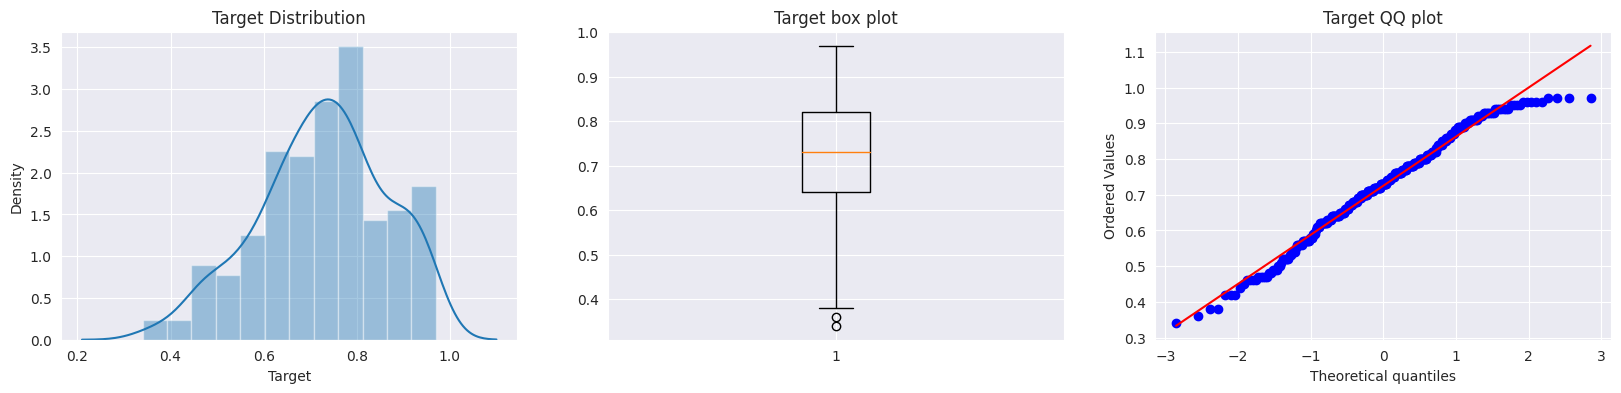

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(131)
sns.distplot(df.Target)
plt.title("Target Distribution")

plt.subplot(132)
plt.boxplot(df.Target)
plt.title("Target box plot")

plt.subplot(133)
stats.probplot(df.Target, plot = plt)
plt.title("Target QQ plot")
plt.show()

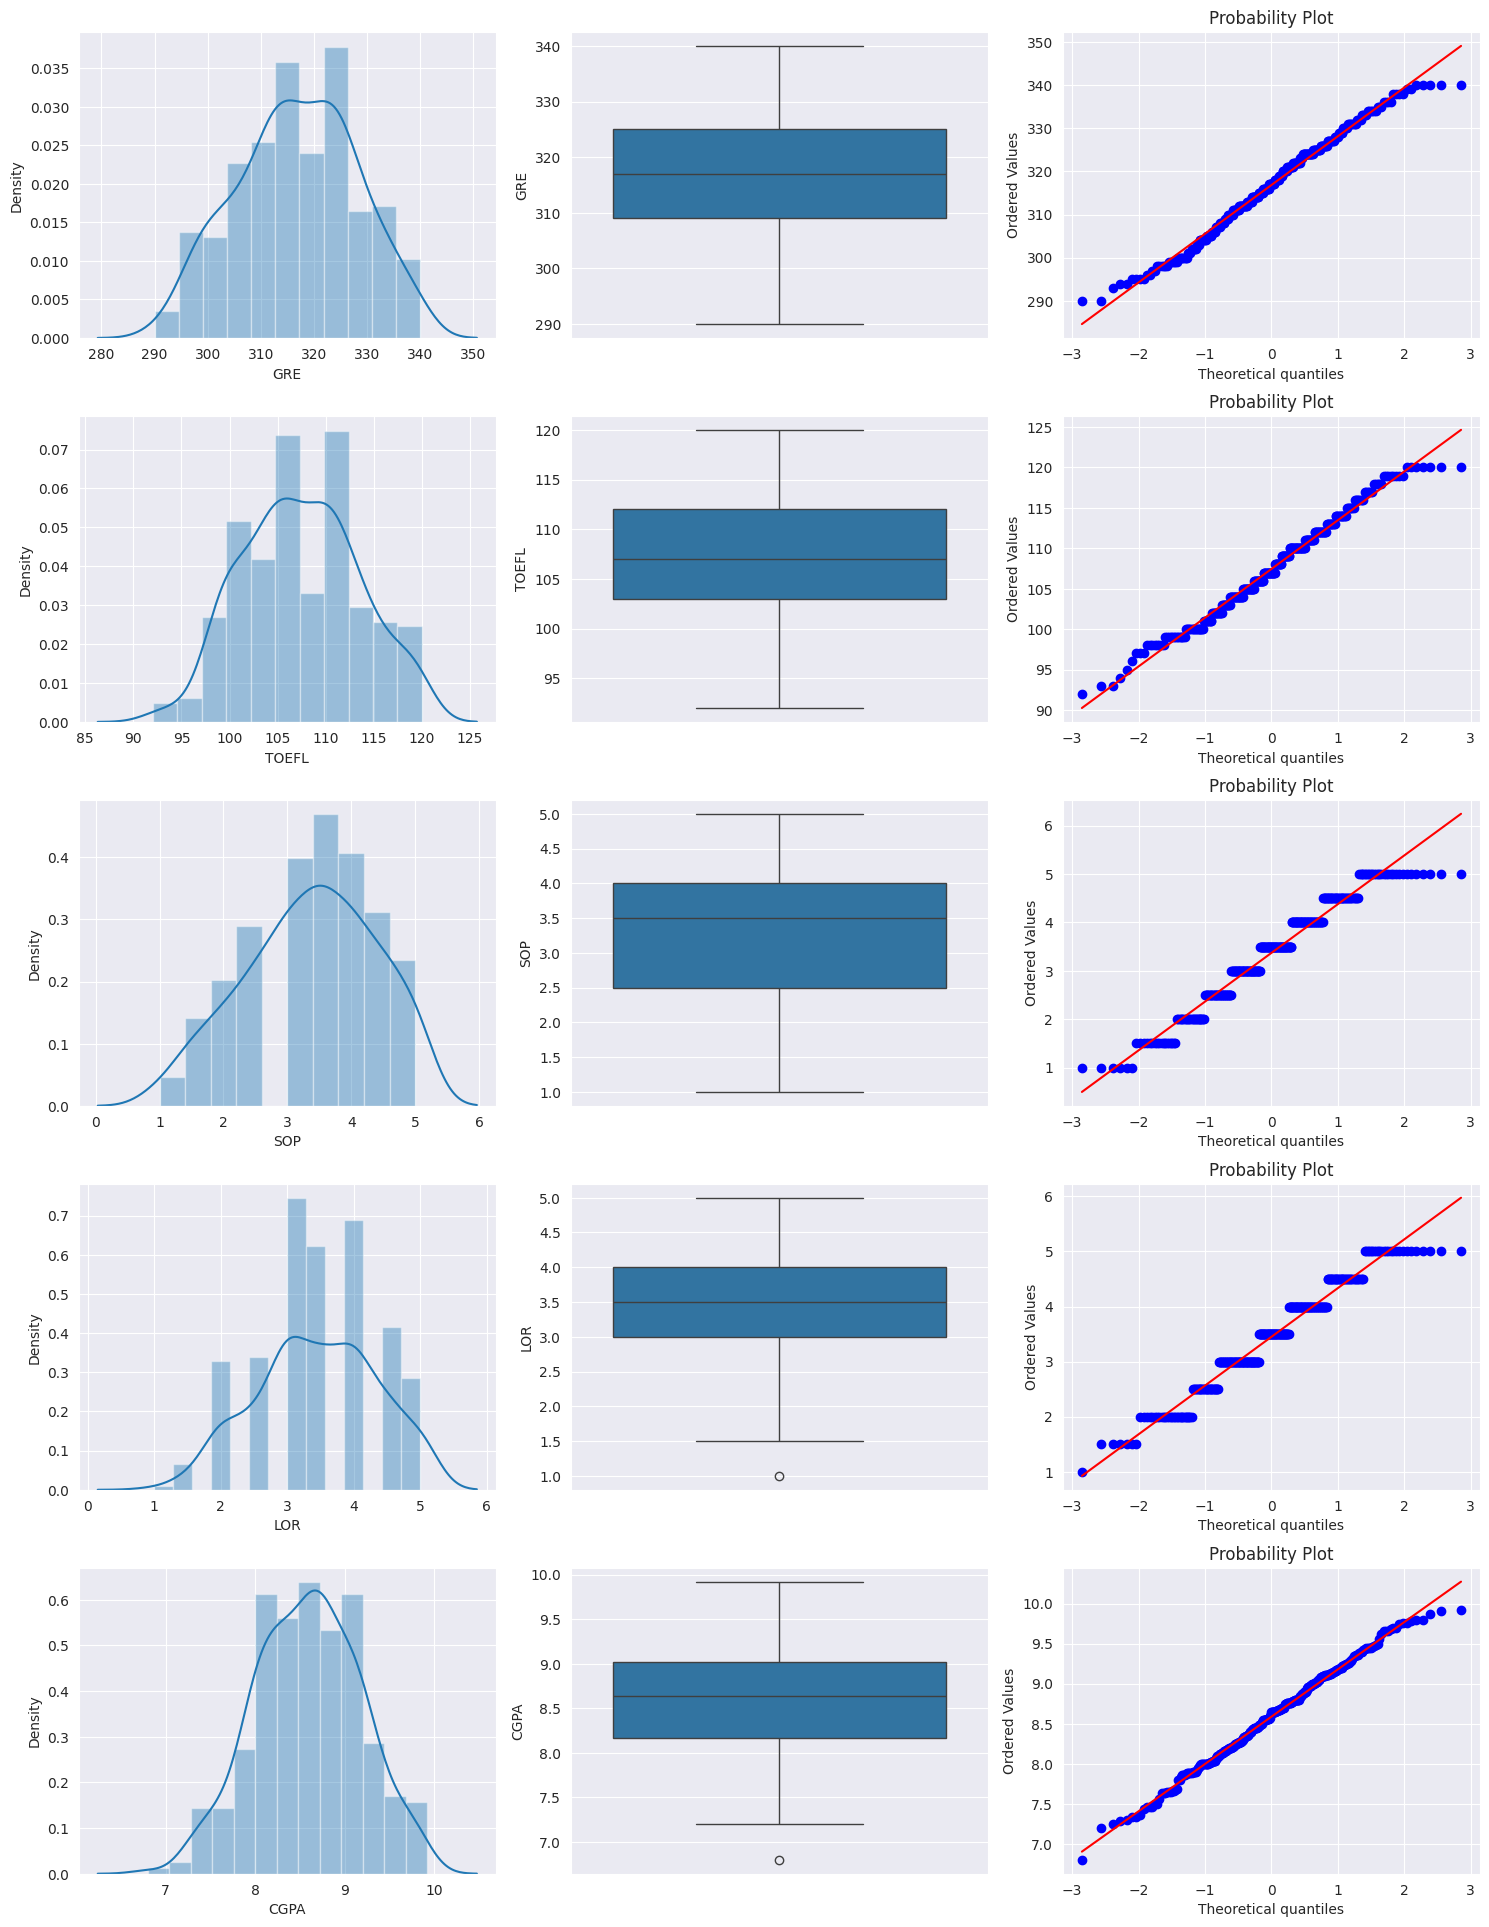

In [ ]:
fig,ax = plt.subplots(len(continuous_variable),3,figsize=(15,20))
for index,i in enumerate(continuous_variable):
    sns.distplot(df[i],ax=ax[index,0])
    sns.boxplot(df[i],ax=ax[index,1])
    stats.probplot(df[i],plot=ax[index,2])

fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

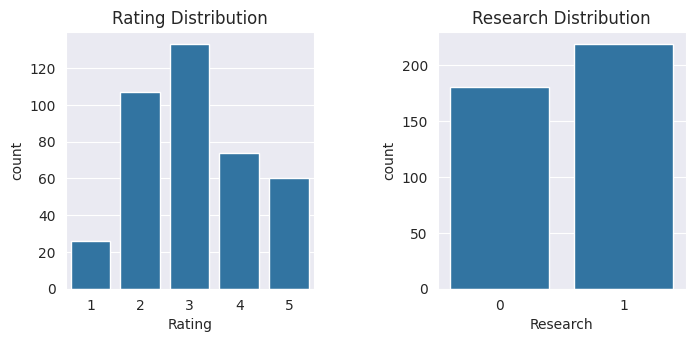

In [ ]:
grid = gridspec.GridSpec(2,2)
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace= 0.5, hspace= 0.4)

for idx, feature in enumerate(discrete_variable):
    ax = plt.subplot(grid[idx])

    sns.countplot(x=df[feature],
                ax=ax)
    ax.set_title(f'{feature} Distribution')

plt.show()

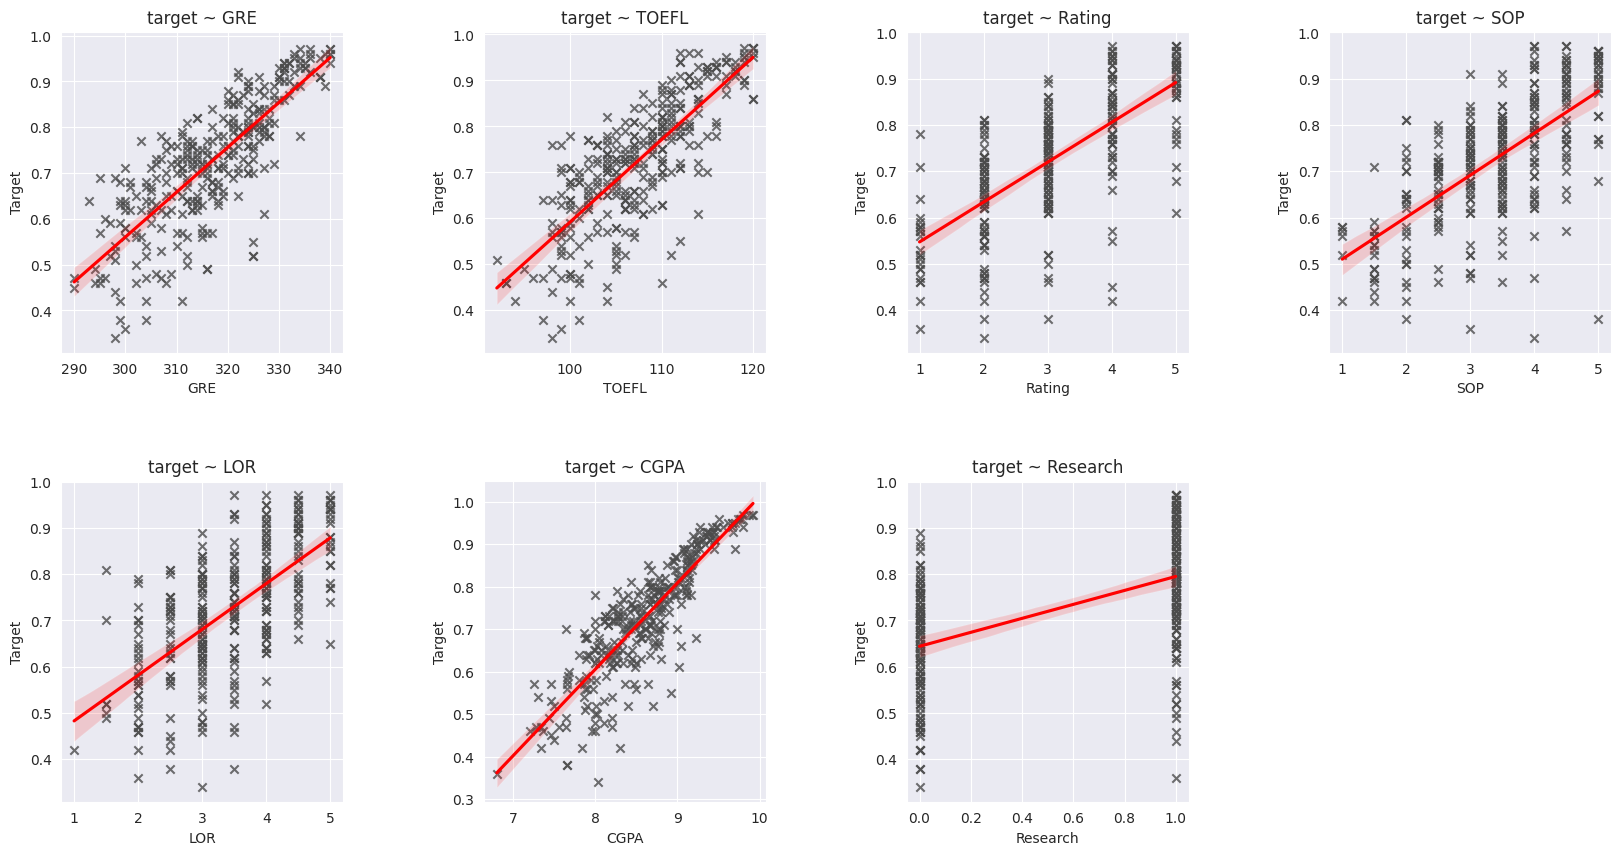

In [ ]:
grid = gridspec.GridSpec(2,4)
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace= 0.5, hspace= 0.4)

for idx, feature in enumerate(df.columns[1:-1]):
    ax = plt.subplot(grid[idx])
    sns.regplot(x=feature, y ='Target', data = df ,ci=99, marker="x", color=".3", line_kws=dict(color="r"))
    ax.set_title(f'target ~ {feature}')

plt.savefig("/content/drive/MyDrive/CS/24-1/다변량/reg_plot.png")
plt.show()

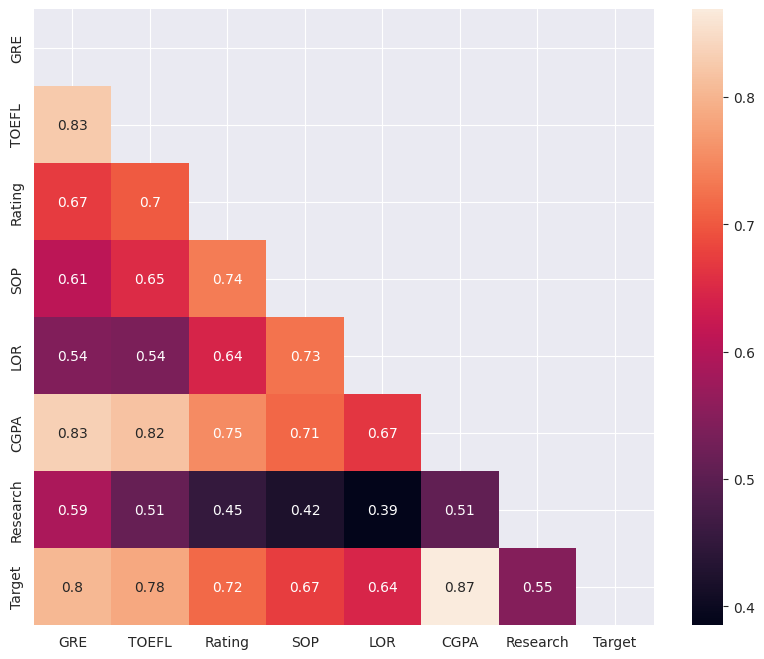

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df.iloc[:,1:].corr(),annot=True, mask=np.triu(df.iloc[:,1:].corr()))

plt.savefig("/content/drive/MyDrive/CS/24-1/다변량/corr_plot.png")
plt.show()

TARGET과의 상관관계는 CGPA, GRE, TOEFL 순으로 높다. 셋 모두 객관적인 지표이다. 마찬가지로 CGPA는 GRE, TOEFL과 상관관계가 높고, GRE와 TOEFL도 상관관계가 높다.

# Modeling


1. Linear Regression
2. Natural Cubic Spline
3. Ridge regression
4. Principal Component Regression
5. Factor Score Regression
6. Partial Least Sqaures


정확도가 비슷할 경우 해석이 쉬운 모델을 선택 -> 회귀 계수를 확인




정성적 지표(SOP, LOR, UNIV.RATING) VS 정량적 지표(GRE, TOEFL, CGPA)
test data에 돌려서 정확도를 넣어서, 6~80퍼대 합격률 갖고있는 데이터 중에, 회귀계수를 이용하여, 어떠한 지표를 올리면 좋을지 컨설팅하는 느낌


In [ ]:
df.columns

Index(['id', 'GRE', 'TOEFL', 'Rating', 'SOP', 'LOR', 'CGPA', 'Research',
       'Target'],
      dtype='object')

In [ ]:
X = df[['GRE', 'TOEFL', 'Rating', 'SOP', 'LOR', 'CGPA', 'Research']]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
pca = PCA(n_components=2, random_state=42)
pca.fit(X_scaled)
pr_comp = pca.transform(X_scaled)

PCA vs PLS

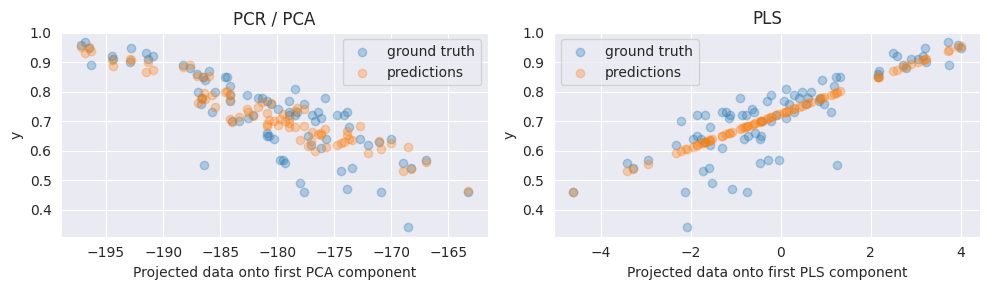

In [ ]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

Polynomial features

In [ ]:
poly2 =  PolynomialFeatures(2)
X_poly2 = poly2.fit_transform(X_scaled)

X_poly2.shape

(320, 28)

Factor anaysis

Kernel Regression

In [ ]:
from sklearn.utils import resample
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, TransformerMixin

class LocalRegression(BaseEstimator):
    def __init__(self, model, kernel_size = 1):
        self.model = model
        self.kernel_size = kernel_size

    def fit(self,X, y):
        self.X, self.y = X, y
        return self

    def predict_proba(self, X):
        return self.__predict(X, self.model.predict_proba)

    def predict(self, X):
        return self.__predict(X, self.model.predict)

    def __predict(self, X, fnc):
        result = []

        for i in range(X.shape[0]):
            self.model.fit(self.X, self.y, sample_weight=self.tri_cube_kernel_with_NN_window(X[i:i + 1, :]))

            result.append(np.atleast_2d(fnc([X[i]])))

        return np.vstack(result)

    def tri_cube_kernel_with_NN_window(self, x0):
        points_cnt = self.kernel_size

        if points_cnt <= 1: # then input will be fraction
            points_cnt = int(self.X.shape[0] * points_cnt)

        distances = cdist(self.X, x0)
        kernel_points_indices = np.argpartition(distances, points_cnt, axis=0)[:points_cnt]
        max_distance = np.max(distances[kernel_points_indices])

        t = distances/max_distance
        result = (t <= 1)*(1-t**3)**3
        return np.squeeze(result)

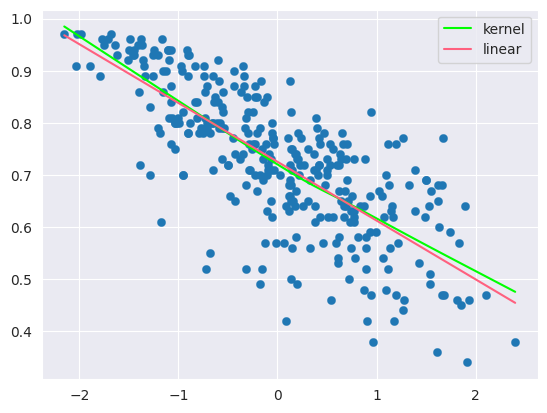

In [ ]:
X = fa_scores[:, :1]
reg = LinearRegression()
xx = np.linspace(np.min(X), np.max(X), 50)
yy = LocalRegression(model=LinearRegression(), kernel_size=0.9).fit(X, y).predict(np.atleast_2d(xx).T)
yyy = reg.fit(X, y).predict(np.atleast_2d(xx).T)
plt.scatter(fa_scores[:,0],y, linewidth=0.2)
plt.plot(xx, yy,color='#00FF00', label='kernel')
plt.plot(xx, yyy, color='#FF607F', label = 'linear')
plt.legend()
plt.show()

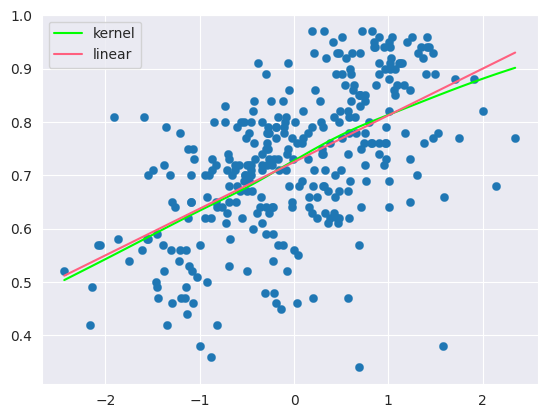

In [ ]:
X = fa_scores[:, 1:2]
reg = LinearRegression()
xx = np.linspace(np.min(X), np.max(X), 50)
yy = LocalRegression(model=LinearRegression(), kernel_size=0.9).fit(X, y).predict(np.atleast_2d(xx).T)
yyy = reg.fit(X, y).predict(np.atleast_2d(xx).T)
plt.scatter(fa_scores[:,1],y, linewidth=0.2)
plt.plot(xx, yy,color='#00FF00', label='kernel')
plt.plot(xx, yyy, color='#FF607F', label = 'linear')
plt.legend()
plt.show()

Natural cubic spline

In [ ]:
class NaturalCubicSplineFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, knots=None, df=None):
        self.knots = knots
        self.df = df # (df+1)-knots calculated at uniform quantiles

    def fit(self,X,y=None):
        if self.df is not None:
            quantiles = np.linspace(0,1,self.df + 1)
            self.knots = []
            for i in range(X.shape[1]):
                self.knots.append(np.unique(np.quantile(X[:,i], quantiles)))


        self.dfs_ = np.array([len(k)-1 for k in self.knots])
        dfs_cumsum = [0] + list(np.cumsum(self.dfs_))
        self.positions_ =  [(dfs_cumsum[i-1], dfs_cumsum[i]-1) for i in range(1, len(dfs_cumsum))]
        return self

    def transform(self,X):
        features_basis_splines = []
        for i in range(X.shape[1]):
            features_basis_splines.append(
                self.__expand_natural_cubic(X[:, i:i+1], self.knots[i]))

        return np.hstack(features_basis_splines)


    @staticmethod
    def __dk(X,k,k_last):
        return (X-k).clip(0) **3 / (k_last - k)

    @staticmethod
    def __expand_natural_cubic(X,ks):
        basis_splines = [X]
        dki_last = NaturalCubicSplineFeatures.__dk(X,ks[-2],ks[-1])
        for knot in ks[:-2]:
            dki = NaturalCubicSplineFeatures.__dk(X,knot,ks[-1])
            basis_splines.append(dki - dki_last)

        return np.hstack(basis_splines)

In [ ]:
poly_ridge_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

poly_pls_pipeline =  Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('pls', PLSRegression()),
])

poly_pcr_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler1', StandardScaler()),
    ('pca', PCA()),
    ('scaler2', StandardScaler()),
    ('lr', LinearRegression())
])


poly_fa_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler1', StandardScaler()),
    ('factor', FactorAnalysis(rotation='varimax')),
    ('scaler2', StandardScaler()),
    ('lr', LinearRegression())
])

add_intercept = FunctionTransformer(
    lambda X: sm.add_constant(X), validate=True)


spline_ridge_pipeline = Pipeline([
                          ('scale_features', StandardScaler()),
                          ("expand_basis",NaturalCubicSplineFeatures()),
                          ('scale_basis',StandardScaler()),
                          ('add_intercept_column', add_intercept),
                          ('ridge', Ridge())
                         ])

spline_pls_pipeline = Pipeline([
                          ('scale_features', StandardScaler()),
                          ("expand_basis",NaturalCubicSplineFeatures()),
                          ('scale_basis',StandardScaler()),
                          ('add_intercept_column', add_intercept),
                          ('pls', PLSRegression())
                         ])

spline_pcr_pipeline = Pipeline([
                          ('scale_features', StandardScaler()),
                          ("expand_basis",NaturalCubicSplineFeatures()),
                          ('scale_basis',StandardScaler()),
                          ('add_intercept_column', add_intercept),
                          ('pca', PCA()),
                          ('scaler', StandardScaler()),
                          ('lr', LinearRegression())
                         ])

spline_fa_pipeline = Pipeline([
                          ('scale_features', StandardScaler()),
                          ("expand_basis",NaturalCubicSplineFeatures()),
                          ('scale_basis',StandardScaler()),
                          ('add_intercept_column', add_intercept),
                          ('factor', FactorAnalysis(rotation='varimax')),
                          ('scaler', StandardScaler()),
                          ('lr', LinearRegression())
                         ])

In [ ]:
param_poly_ridge = {
    'poly__degree': [1, 2, 3],
    'ridge__alpha': [3,5,7]
}

param_poly_pls = {
    'poly__degree': [1, 2, 3],
    'pls__n_components': [2,3]
}

param_poly_pcr = {
    'poly__degree': [1, 2, 3],
    'pca__n_components': [2,3]
}

param_poly_fa = {
    'poly__degree': [1, 2, 3],
    'factor__n_components': [1, 2, 3]
}

param_spline_ridge = {
    'expand_basis__df' : [1,2,3],
    'ridge__alpha' : [7,9,11,13]
}


param_spline_pls = {
    'expand_basis__df' : [1,2,3],
    'pls__n_components': [2,3]
}

param_spline_pcr = {
    'expand_basis__df' : [1,2,3],
    'pca__n_components': [2,3]
}

param_spline_fa = {
    'expand_basis__df' : [1,2,3],
    'factor__n_components': [2, 3]
}

cv = KFold(n_splits=3, random_state=2, shuffle=True)

grid_poly_ridge = GridSearchCV(poly_ridge_pipeline, param_poly_ridge, cv=cv, scoring='neg_mean_absolute_error')
grid_poly_pls = GridSearchCV(poly_pls_pipeline,param_poly_pls, cv=cv, scoring='neg_mean_absolute_error')
grid_poly_pcr = GridSearchCV(poly_pcr_pipeline, param_poly_pcr, cv=cv, scoring='neg_mean_absolute_error')
grid_poly_fa = GridSearchCV(poly_fa_pipeline, param_poly_fa, cv=cv, scoring='neg_mean_absolute_error')

grid_spline_ridge = GridSearchCV(spline_ridge_pipeline, param_spline_ridge, cv=cv, scoring='neg_mean_absolute_error')
grid_spline_pls = GridSearchCV(spline_pls_pipeline,param_spline_pls, cv=cv, scoring='neg_mean_absolute_error')
grid_spline_pcr = GridSearchCV(spline_pcr_pipeline, param_spline_pcr, cv=cv, scoring='neg_mean_absolute_error')
grid_spline_fa = GridSearchCV(spline_fa_pipeline, param_spline_fa, cv=cv, scoring='neg_mean_absolute_error')

In [ ]:
grids_poly = [grid_poly_ridge, grid_poly_pls, grid_poly_pcr , grid_poly_fa]
grids_spline = [grid_spline_ridge, grid_spline_pls, grid_spline_pcr , grid_spline_fa]
for pipe in grids_poly:
    pipe.fit(X_train,y_train)

In [ ]:
for pipe in grids_spline:
    pipe.fit(X_train,y_train)

In [ ]:
poly_dict = {
             0: 'Polynomial Regression',
             1: 'Polynomial Partial Least Squares',
             2: 'Polynomial Principal Components Regression',
             3: 'Polynomial Factor Scores Regression'
             }

spline_dict = {
             0: 'Spline regression',
             1: 'Spline Partial Least Squares',
             2: 'Spline Principal Components Regression',
             3: 'Spline Factor Scores Regression'
             }

for i, model in enumerate(grids_poly):
    print('{} Test Accuracy: {}'.format(poly_dict[i],
    -model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(poly_dict[i],          model.best_params_))
    print('===============================================================================================')

for i, model in enumerate(grids_spline):
    print('{} Test Accuracy: {}'.format(spline_dict[i],
    -model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(spline_dict[i],          model.best_params_))
    print('===============================================================================================')

Polynomial Regression Test Accuracy: 0.055132127833670566
Polynomial Regression Best Params: {'poly__degree': 1, 'ridge__alpha': 7}
Polynomial Partial Least Squares Test Accuracy: 0.054419547140660184
Polynomial Partial Least Squares Best Params: {'pls__n_components': 3, 'poly__degree': 2}
Polynomial Principal Components Regression Test Accuracy: 0.055288720651645716
Polynomial Principal Components Regression Best Params: {'pca__n_components': 2, 'poly__degree': 1}
Polynomial Factor Scores Regression Test Accuracy: 0.05324847151161114
Polynomial Factor Scores Regression Best Params: {'factor__n_components': 1, 'poly__degree': 1}
Spline regression Test Accuracy: 0.054995315836628186
Spline regression Best Params: {'expand_basis__df': 1, 'ridge__alpha': 9}
Spline Partial Least Squares Test Accuracy: 0.054557336036778724
Spline Partial Least Squares Best Params: {'expand_basis__df': 1, 'pls__n_components': 3}
Spline Principal Components Regression Test Accuracy: 0.05528872065164571
Spline

In [ ]:
X_scaled = scaler.fit_transform(X)
fa = FactorAnalysis(rotation='varimax', n_components=1)
fa.fit(X_scaled)

fa_scores = fa.transform(X)
loadings =  fa.components_
loadings

array([[-0.88129667, -0.87876834, -0.81470246, -0.77719677, -0.70095958,
        -0.93119702, -0.57791232]])

In [ ]:
X.columns

Index(['GRE', 'TOEFL', 'Rating', 'SOP', 'LOR', 'CGPA', 'Research'], dtype='object')

In [ ]:
param_poly_fa = {
    'poly__degree': [1,2,3],
    'factor__n_components': [2]
}

grid_poly_fa = GridSearchCV(poly_fa_pipeline, param_poly_fa, cv=cv, scoring='neg_mean_absolute_error')
grid_poly_fa.fit(X_train, y_train)
grid_poly_fa.best_params_

{'factor__n_components': 2, 'poly__degree': 1}

In [ ]:
-grid_poly_fa.score(X_test, y_test)

0.05356901010001881

In [ ]:
X_scaled = scaler.fit_transform(X)
fa = FactorAnalysis(rotation='varimax', n_components=2)
fa.fit(X_scaled)

fa_scores = fa.transform(X)
fa_scores_scaled = scaler.fit_transform(fa_scores)
loadings =  fa.components_

df_fa = pd.DataFrame({'Feature' : ['GRE', 'TOEFL', 'Rating', 'SOP', 'LOR', 'CGPA','Research'], 'Factor1': loadings[0,:], 'Factor2':loadings[1,:]})
df_fa

,Feature,Factor1,Factor2
0,GRE,-0.883326,0.323891
1,TOEFL,-0.787964,0.414079
2,Rating,-0.530769,0.652392
3,SOP,-0.396399,0.799303
4,LOR,-0.337069,0.736249
5,CGPA,-0.745533,0.539397
6,Research,-0.549037,0.244209


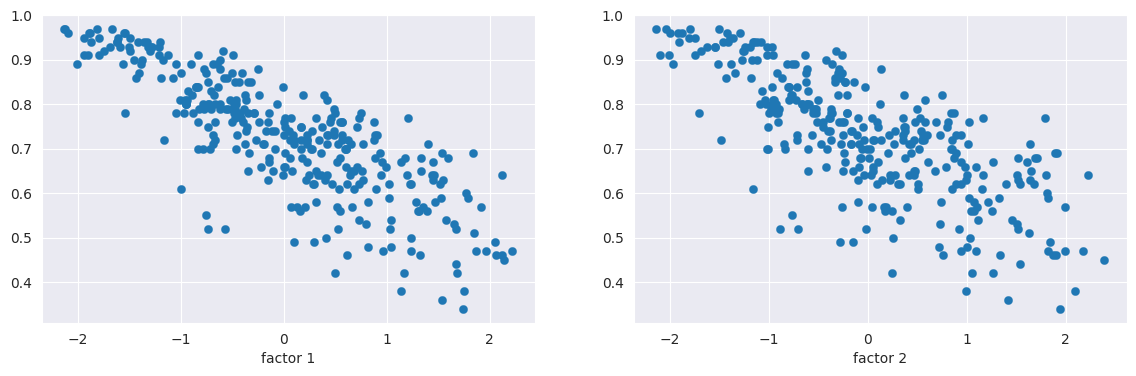

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.scatter(fa_scores_scaled[:,0],y, linewidth=0.2)
plt.xlabel('factor 1')
plt.subplot(122)
plt.scatter(fa_scores_scaled[:,1],y, linewidth=0.2)
plt.xlabel('factor 2')

plt.show()

In [ ]:
fin_model_pipeline = Pipeline([
    ('scaler1', StandardScaler()),
    ('factor', FactorAnalysis(rotation='varimax', n_components=2)),
    ('scaler2', StandardScaler()),
    ('lr', LinearRegression())
])
fin_model_pipeline.fit(X, y)

Pipeline(steps=[('scaler1', StandardScaler()),
                ('factor', FactorAnalysis(n_components=2, rotation='varimax')),
                ('scaler2', StandardScaler()), ('lr', LinearRegression())])

In [ ]:
fin_model_pipeline.named_steps['lr'].coef_

array([-0.09444863,  0.06186188])

In [ ]:
fin_model_pipeline.get_params()

{'memory': None,
 'steps': [('scaler1', StandardScaler()),
  ('factor', FactorAnalysis(n_components=2, rotation='varimax')),
  ('scaler2', StandardScaler()),
  ('lr', LinearRegression())],
 'verbose': False,
 'scaler1': StandardScaler(),
 'factor': FactorAnalysis(n_components=2, rotation='varimax'),
 'scaler2': StandardScaler(),
 'lr': LinearRegression(),
 'scaler1__copy': True,
 'scaler1__with_mean': True,
 'scaler1__with_std': True,
 'factor__copy': True,
 'factor__iterated_power': 3,
 'factor__max_iter': 1000,
 'factor__n_components': 2,
 'factor__noise_variance_init': None,
 'factor__random_state': 0,
 'factor__rotation': 'varimax',
 'factor__svd_method': 'randomized',
 'factor__tol': 0.01,
 'scaler2__copy': True,
 'scaler2__with_mean': True,
 'scaler2__with_std': True,
 'lr__copy_X': True,
 'lr__fit_intercept': True,
 'lr__n_jobs': None,
 'lr__positive': False}

## Bootstrap method (.632+ estimator)

에러가 허용할만한 에러

In [ ]:
def bootstrap_est(pipeline):
    model = pipeline
    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)

    in_sample_err = mean_absolute_error(y_train, y_pred)
    oob_err = 0

    for round in range(200):
        X_train_re, y_train_re = resample(X_train, y_train)
        X_train_oob, y_train_re_oob = X_train[~X_train.index.isin(np.unique(X_train_re.index))], y_train[~X_train.index.isin(np.unique(X_train_re.index))]

        model.fit(X_train_re, y_train_re)

        y_pred_oob = model.predict(X_train_oob)

        oob_err += mean_absolute_error(y_train_re_oob, y_pred_oob)


    oob_err /= 200
    gamma_hat = 0

    for i in range(len(y_pred)):
        for j in range(len(y_train)):
            gamma_hat += abs(y_pred[i] - y_train.values[j])

    gamma_hat /= len(y_train)**2
    gamma_hat

    relative_overfitting_rate = max(oob_err - in_sample_err, 0) / (gamma_hat - in_sample_err + 1e-8)
    w_hat = 0.632 / (1 - 0.368 * relative_overfitting_rate)
    err_632_p = (1-w_hat) * in_sample_err + w_hat * oob_err
    return err_632_p


In [ ]:
ridge_pipe = make_pipeline(PolynomialFeatures(), StandardScaler(), Ridge())
pcr_pipe = make_pipeline(PolynomialFeatures(), StandardScaler(), PCA(), LinearRegression())
pls_pipe = make_pipeline(PolynomialFeatures(), StandardScaler(), PLSRegression())
fa_pipe = make_pipeline(PolynomialFeatures(), StandardScaler(), FactorAnalysis(rotation='varimax'), LinearRegression())

In [ ]:
degree_li = [1,2,3]
alpha_li = [3,5,7]
err = 100
best_degree = -1
best_alpha = -1
for degree in degree_li:
    for alpha in alpha_li:
        ridge_pipe = make_pipeline(PolynomialFeatures(degree), StandardScaler(), Ridge(alpha=alpha))
        cur_err = bootstrap_est(ridge_pipe)
        if err > cur_err:
            err = cur_err
            best_degree = degree
            best_alpha = alpha

In [ ]:
print("Ridge: ", err, best_degree, best_alpha)

Ridge:  0.041729149494510384 1 7


In [ ]:
degree_li = [1,2,3]
n_components_li = [2,3,4]

err = 100
best_degree = -1
best_n_components = -1
for degree in degree_li:
    for n_components in n_components_li:
        pls_pipe = make_pipeline(PolynomialFeatures(degree), StandardScaler(), PLSRegression(n_components))
        cur_err = bootstrap_est(pls_pipe)
        if err > cur_err:
            err = cur_err
            best_degree = degree
            best_n_components = n_components

In [ ]:
print("PLS: ", err, best_degree, best_n_components)

PLS:  [0.04207767] 1 3


In [ ]:
degree_li = [1,2,3]
n_components_li = [2,3,4]

err = 100
best_degree = -1
best_n_components = -1
for degree in degree_li:
    for n_components in n_components_li:
        pls_pipe = make_pipeline(PolynomialFeatures(degree), StandardScaler(), PCA(n_components), LinearRegression())
        cur_err = bootstrap_est(pls_pipe)
        if err > cur_err:
            err = cur_err
            best_degree = degree
            best_n_components = n_components

In [ ]:
print("PCR: ", err, best_degree, best_n_components)

PCR:  0.04436776085043417 2 5


In [ ]:
degree_li = [1, 2, 3]
n_components_li = [2,3,4]

err = 100
best_degree = -1
best_n_components = -1
for degree in degree_li:
    for n_components in n_components_li:
        fa_pipe = make_pipeline(PolynomialFeatures(degree), StandardScaler(), FactorAnalysis(rotation='varimax', n_components=n_components), LinearRegression())
        cur_err = bootstrap_est(fa_pipe)
        if err > cur_err:
            err = cur_err
            best_degree = degree
            best_n_components = n_components

In [ ]:
print("FAR: ", err, best_degree, best_n_components)

FAR:  0.042526918398074404 1 4


## Test

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/CS/24-1/다변량/Dataset/test.csv")
test_df.columns = ['id','GRE','TOEFL','Rating','SOP','LOR','CGPA','Research','Target']
test_df.head()

,id,GRE,TOEFL,Rating,SOP,LOR,CGPA,Research,Target
0,210,301,104,3,3.5,4.0,8.12,1,0.68
1,281,311,102,3,4.5,4.0,8.64,1,0.68
2,34,340,114,5,4.0,4.0,9.60,1,0.90
3,211,325,108,4,4.5,4.0,9.06,1,0.79
4,94,301,97,2,3.0,3.0,7.88,1,0.44


In [ ]:
X_test = test_df[['GRE', 'TOEFL', 'Rating', 'SOP', 'LOR', 'CGPA', 'Research']]
y_test = test_df['Target']

In [ ]:
test_df['Target_est'] = fin_model_pipeline.predict(X_test)
test_df['Target']
test_df['absolute_est_error'] = test_df['Target'] - test_df['Target_est']
test_df.head(40)

,id,GRE,TOEFL,Rating,SOP,LOR,CGPA,Research,Target,Target_est,absolute_est_error
0,210,301,104,3,3.5,4.0,8.12,1,0.68,0.639203,0.040797
1,281,311,102,3,4.5,4.0,8.64,1,0.68,0.712601,-0.032601
2,34,340,114,5,4.0,4.0,9.60,1,0.90,0.931395,-0.031395
3,211,325,108,4,4.5,4.0,9.06,1,0.79,0.820997,-0.030997
4,94,301,97,2,3.0,3.0,7.88,1,0.44,0.572195,-0.132195
5,85,340,115,5,4.5,4.5,9.45,1,0.94,0.940108,-0.000108
6,330,297,96,2,2.5,1.5,7.89,0,0.43,0.521662,-0.091662
7,95,303,99,3,2.0,2.5,7.66,0,0.36,0.556483,-0.196483
8,267,312,105,2,2.0,2.5,8.45,0,0.72,0.642520,0.077480
9,127,323,113,3,4.0,3.0,9.32,1,0.85,0.816679,0.033321


In [ ]:
mean_absolute_error(test_df['Target'],  test_df['Target_est'])

0.05236914228363726

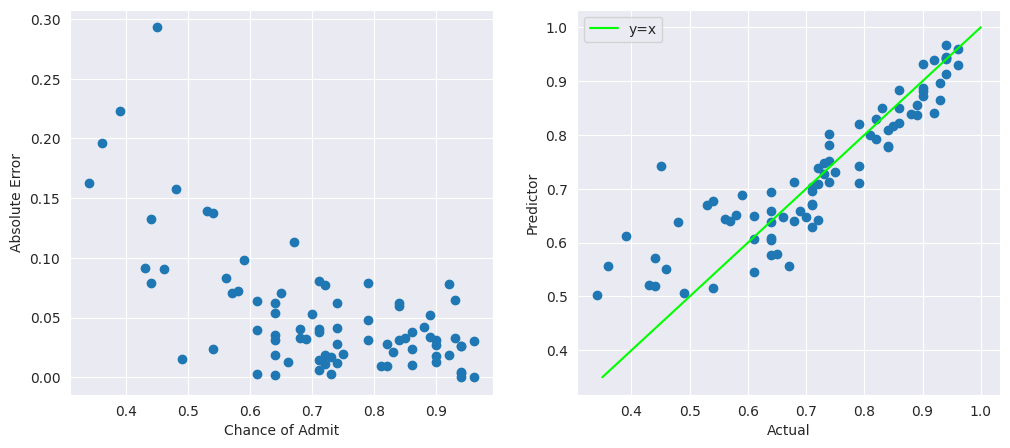

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(test_df['Target'], abs(test_df['absolute_est_error']))
plt.xlabel("Chance of Admit")
plt.ylabel("Absolute Error")

plt.subplot(122)
xx = np.linspace(0.35, 1, 100)
plt.scatter(test_df['Target'], test_df['Target_est'])
plt.plot(xx, xx,color='#00FF00', label='y=x')
plt.xlabel("Actual")
plt.ylabel("Predictor")
plt.legend()

plt.savefig('/content/drive/MyDrive/CS/24-1/다변량/result.png')

plt.show()